# Naive Bayes: Three Examples

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.dummy import DummyClassifier
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

## Gaussian Example: 
Let's work on using height and weight to predict gender. The data is from the repo for the book Machine Learning for Hackers.

In [2]:
data = pd.read_csv('data/height_weight_gender.csv')

In [3]:
data['Gender'] = (data['Gender'] != 'Male').astype(int)

In [4]:
data.Gender.value_counts()

0    5000
1    5000
Name: Gender, dtype: int64

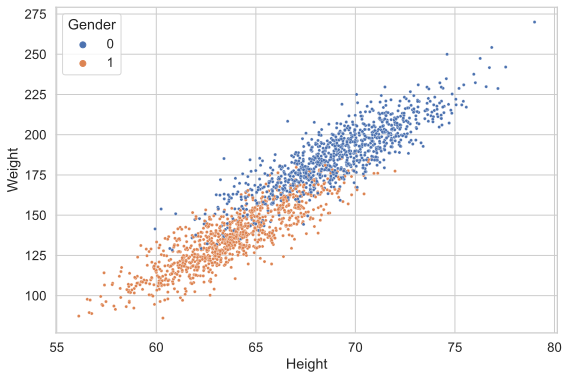

In [5]:
sns.scatterplot(data=data.sample(2000), x='Height', y='Weight', hue='Gender', s=10);

In [6]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
X.head()

Height      Weight
0  73.847017  241.893563
1  68.781904  162.310473
2  74.110105  212.740856
3  71.730978  220.042470
4  69.881796  206.349801

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.887

In [9]:
nb.theta_ # mean of each feature by class

array([[ 68.9900513 , 186.76084224],
       [ 63.70633072, 135.85586208]])

In [10]:
np.sqrt(nb.sigma_) # variance of each feature by class

array([[ 2.88690446, 19.90792104],
       [ 2.69939185, 18.94517396]])

In [11]:
def plot_gaussian(lb, ub, mean=0, std=1, n=200, axis=0, mult=300, add=50):
    '''
    Draw a Gaussian curve on one of the axes, given a lower-bound (lb) and upper-bound (ub)
    '''
    x = np.linspace(lb, ub, n)
    pdf = st.norm.pdf(x, loc=mean, scale=std)
    
    if axis == 0:
        plt.plot(x, pdf * mult + add)
    else:
        plt.plot(pdf * mult + add, x)

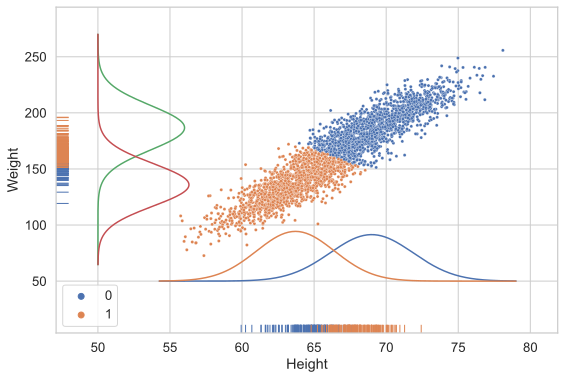

In [12]:
for feature in range(2):
    for gender in range(2):
        plot_gaussian(X_train.iloc[:, feature].min(), 
                      X_train.iloc[:, feature].max(), 
                      nb.theta_[gender][feature],  # See above
                      np.sqrt(nb.sigma_)[gender][feature],  # See above
                      axis=feature)
        
preds = nb.predict(X_test)
wrong_mask = y_test != preds

sns.scatterplot(data=X_test, x='Height', y='Weight', hue=preds, s=10)
sns.rugplot(data=X_test[wrong_mask], x='Height', y='Weight', hue=y_test, legend=False);

## Bernoulli Example: Now let's try votes!

In [13]:
def generate_congress_data(num_congressmen=100):
    votes = [0,1]
    senators = np.random.choice(votes, replace=True, size=(num_congressmen,4))
    df = pd.DataFrame(senators, columns=['vote1','vote2','vote3','vote4'])
    
    def calculate_party(row):
        x = row['vote1']
        y = row['vote2']
        z = row['vote3']

        party = 0.7*x + 0.5*y - z + np.random.normal(0,0.3)
        if party > 0.1:
            return 'Dem'
        elif party > 0.01:
            return 'Ind'
        else:
            return 'Rep'
    
    df['party'] = df.apply(calculate_party,axis=1)
    print(df.party.value_counts())
    return df.iloc[:,:-1],df.iloc[:,-1]

X, y = generate_congress_data(num_congressmen=400)

Dem    196
Rep    188
Ind     16
Name: party, dtype: int64


In [14]:
X.head()

vote1  vote2  vote3  vote4
0      1      0      1      1
1      1      0      1      1
2      1      0      0      1
3      0      1      1      1
4      1      0      1      0

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
nb = BernoulliNB()
nb.fit(X_train,y_train)
nb.score(X_test,y_test)

0.8916666666666667

In [17]:
dc = DummyClassifier() # not for real problems, just a baseline 
dc.fit(X_train, y_train)
dc.score(X_test, y_test)

0.48333333333333334

## Multinomial example: Predicting what a document is about

In [18]:
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
categories = ['alt.atheism', 'comp.graphics', 'rec.sport.baseball']
ng_train = datasets.fetch_20newsgroups(subset='train', 
                                       categories=categories, 
                                       remove=('headers', 
                                               'footers', 'quotes'))

In [32]:
X_train_t, X_test_t, y_train, y_test = train_test_split(ng_train.data, ng_train.target,
                                                        test_size=0.3, random_state=42)

In [33]:
print(X_train_t[0])



	The defenition of the Underdog is a team that has no talent and comes
out of nowhere to contend.  The '69 Mets and '89 Orioles are prime examples,
not the Cubs.  I root for the Cubs, because I feel sorry for them, but 
basically they are dogs.  The Pirates today are a great example of an underdog.
If the Rockies and Marlins compete, they will be underdogs.  The North Stars
trip to the Stanley Cup finals was a good example of an underdog's journey. 
The Cubs have a good team this year, and play in a weak division, they are much
less than America's Team.




In [34]:
# Convert a collection of text documents to a matrix of token counts
vec = CountVectorizer(ngram_range=(1, 2),  
                      stop_words='english', 
                      token_pattern="\\b[a-z][a-z]+\\b",
                      lowercase=True,
                      max_df = 0.6)

X_train = vec.fit_transform(X_train_t)
X_test = vec.transform(X_test_t)

In [35]:
X_train.shape

(1162, 85536)

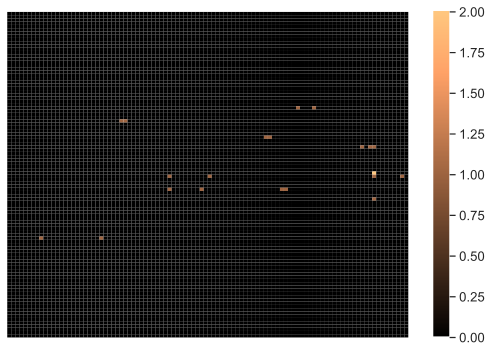

In [36]:
# Let's look at just the upper left corner of this array
sns.heatmap(X_train[:100, :100].toarray(), xticklabels=False, yticklabels=False, cmap='copper');

In [37]:
example = X_train[0].toarray()[0]  # pick one row of the training set

words = vec.get_feature_names()    # get the feature names, i.e., the words terms the corpus
example = pd.Series(data=example, index=words)  # present this in a Pandas series

example.sort_values(ascending=False)[:10]  # show the top 10 used terms in the `example`

underdog            3
cubs                3
team                3
example underdog    2
example             2
good                2
america team        1
feel sorry          1
defenition          1
play                1
dtype: int64

In [38]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.9458917835671342

In [56]:
new_data = X_test_t[19]
print(new_data)


Having thought about this, why don't you project the 2 lines onto the 2d
plane formed by the lines.  Do an intersection calculation in the plane in
2D, where you're guaranteed a unique solution (unless they're parallel which
won't happen in this case), and then use parametric distance along the lines
from the circle centres to determine the exact point of interest.  This
bypasses the messy error propogation required to do the calculation in 3d.

Hope I haven't put my foot in it again!

steve
---


In [57]:
new_X = vec.transform([new_data])

In [58]:
nb.predict(new_X)

array([1])

In [59]:
categories[1]

'comp.graphics'